In [1]:
# Cell 1: Imports and configuration
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid", context="notebook")

DATA_PATH = "Network_anomaly_data.csv"  # adjust if needed
RANDOM_STATE = 42
TOP_N = 20         # for categorical plotting/tables
MAX_NUMERIC_PLOTS = 12  # cap number of numeric hist plots

In [2]:
# Cell 2: Load data and basic feature typing/engineering

# Load
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Normalize column names (lowercase)
df.columns = [c.strip().lower() for c in df.columns]

# Identify label column (KDD-like: 'attack' present)
label_col = "attack" if "attack" in df.columns else None

# Identify likely categorical and numeric columns
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

# Create Attack Binary and Attack Family (KDD-99 mapping) if attack exists
if label_col:
    df["attack_binary"] = np.where(df[label_col].str.lower() == "normal", "Normal", "Attack")

    dos = {"neptune","smurf","teardrop","pod","back","land"}
    probe = {"satan","ipsweep","portsweep","nmap"}
    r2l = {"guess_passwd","ftp_write","multihop","phf","imap","warezmaster","warezclient","spy"}
    u2r = {"buffer_overflow","loadmodule","rootkit","perl"}

    def map_family(x: str) -> str:
        if pd.isna(x): return "Unknown"
        xl = str(x).lower()
        if xl == "normal": return "Normal"
        if xl in dos: return "DoS"
        if xl in probe: return "Probe"
        if xl in r2l: return "R2L"
        if xl in u2r: return "U2R"
        return "OtherAttack"

    df["attack_family"] = df[label_col].apply(map_family)
else:
    print("No 'attack' column detected; downstream hypothesis tests will adapt.")

# Aliases for expected fields (case-insensitive fallback)
def coalesce_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # case-insensitive fallback
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

srcbytes_col = coalesce_col(df, ["srcbytes", "src_bytes", "source_bytes"])
dstbytes_col = coalesce_col(df, ["dstbytes", "dst_bytes", "dest_bytes", "destination_bytes"])
duration_col = coalesce_col(df, ["duration"])
protocol_col = coalesce_col(df, ["protocoltype", "protocol_type", "protocol"])
service_col = coalesce_col(df, ["service"])
flag_col = coalesce_col(df, ["flag"])
urgent_col = coalesce_col(df, ["urgent"])

key_info = {
    "label_col": label_col,
    "srcbytes_col": srcbytes_col,
    "dstbytes_col": dstbytes_col,
    "duration_col": duration_col,
    "protocol_col": protocol_col,
    "service_col": service_col,
    "flag_col": flag_col,
    "urgent_col": urgent_col,
}
key_info

Loaded: 125,973 rows, 44 columns


{'label_col': 'attack',
 'srcbytes_col': 'srcbytes',
 'dstbytes_col': 'dstbytes',
 'duration_col': 'duration',
 'protocol_col': 'protocoltype',
 'service_col': 'service',
 'flag_col': 'flag',
 'urgent_col': 'urgent'}

In [3]:
# Cell 3: Missing values analysis

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing, "missing_pct": missing_pct})
display(missing_df.head(30))

,missing,missing_pct
duration,0,0.0
protocoltype,0,0.0
time,0,0.0
service,0,0.0
flag,0,0.0
srcbytes,0,0.0
dstbytes,0,0.0
land,0,0.0
wrongfragment,0,0.0
urgent,0,0.0


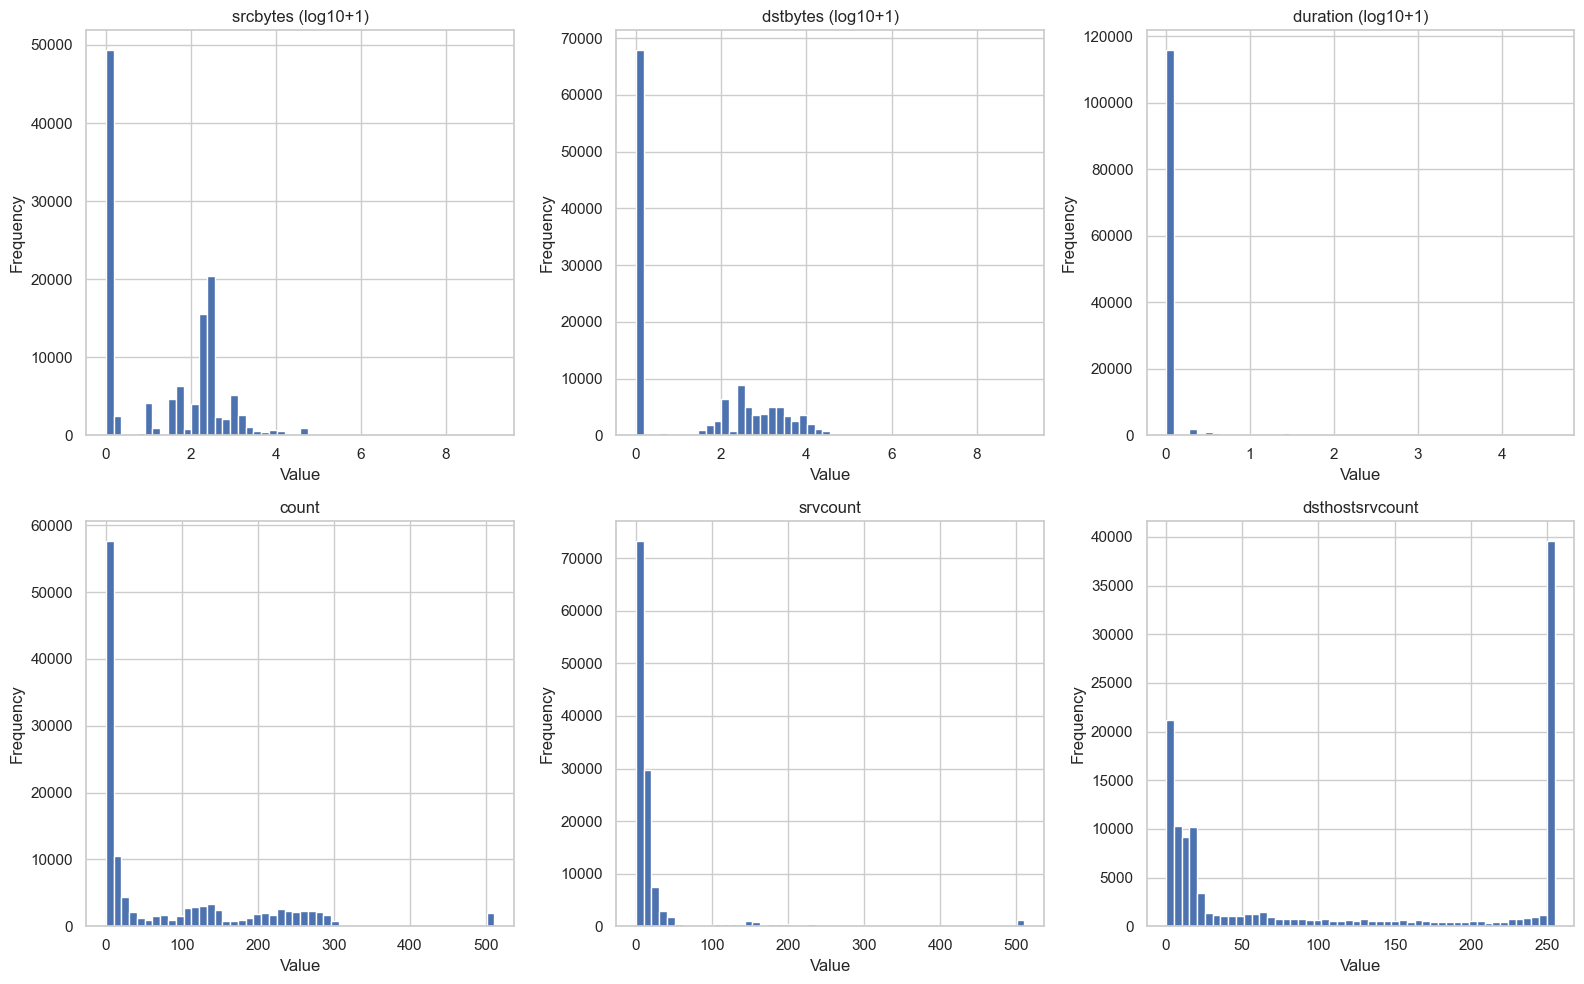

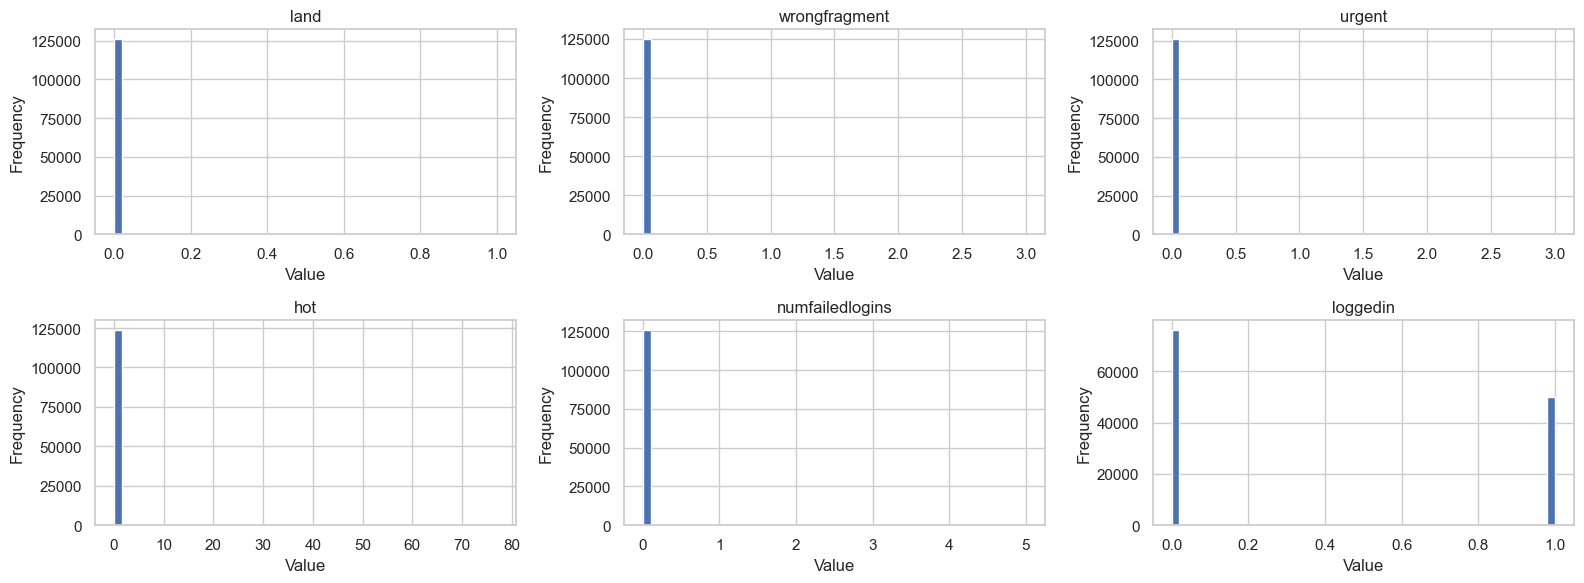

In [4]:
# Cell 4: Distributions of key features (numeric) + generic numerics (capped)

def plot_hist(series, title, log=False, bins=50):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if log:
        s = np.log10(s + 1)
        title += " (log10+1)"
    plt.hist(s, bins=bins, edgecolor="white")
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

key_numeric = [c for c in [srcbytes_col, dstbytes_col, duration_col] if c]
key_numeric += [c for c in ["count", "srvcount", "dsthostsrvcount"] if c in df.columns]
key_numeric = list(dict.fromkeys(key_numeric))

n_to_plot = min(len(key_numeric), 6)
plt.figure(figsize=(16, 10))
for i, col in enumerate(key_numeric[:n_to_plot], 1):
    plt.subplot(int(np.ceil(n_to_plot/3)), 3, i)
    plot_hist(df[col], f"{col}", log=(col in {srcbytes_col, dstbytes_col, duration_col}))
plt.tight_layout()
plt.show()

# Generic numerics (capped)
generic_num = [c for c in num_cols if c not in key_numeric]
generic_num = generic_num[:max(0, MAX_NUMERIC_PLOTS - n_to_plot)]
if generic_num:
    n = len(generic_num)
    plt.figure(figsize=(16, max(6, int(np.ceil(n/3))*3)))
    for i, col in enumerate(generic_num, 1):
        plt.subplot(int(np.ceil(n/3)), 3, i)
        plot_hist(df[col], f"{col}")
    plt.tight_layout()
    plt.show()

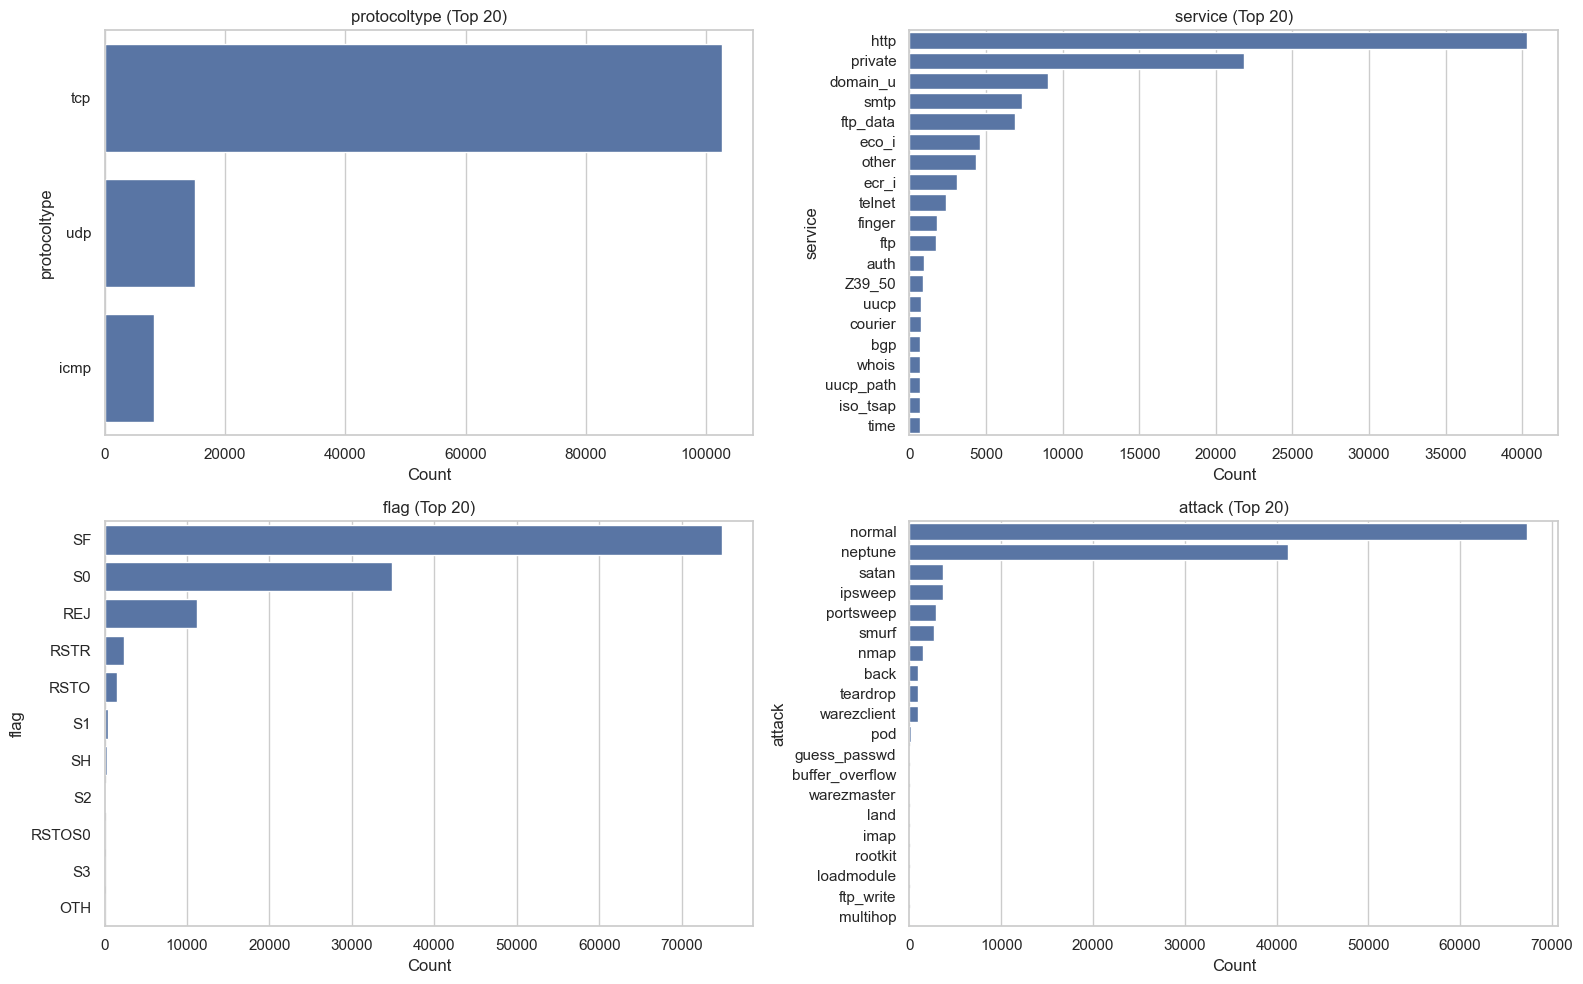

In [5]:
# Cell 5: Categorical distributions (top-N)

def bar_top_counts(series, title, top_n=TOP_N):
    vc = series.astype("string").value_counts().head(top_n)
    sns.barplot(x=vc.values, y=vc.index, orient="h")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel(series.name)

plt.figure(figsize=(16, 10))
plot_cols = [c for c in [protocol_col, service_col, flag_col, label_col] if c]
n = len(plot_cols)
for i, col in enumerate(plot_cols, 1):
    plt.subplot(2, int(np.ceil(n/2)), i)
    bar_top_counts(df[col], f"{col} (Top {TOP_N})")
plt.tight_layout()
plt.show()

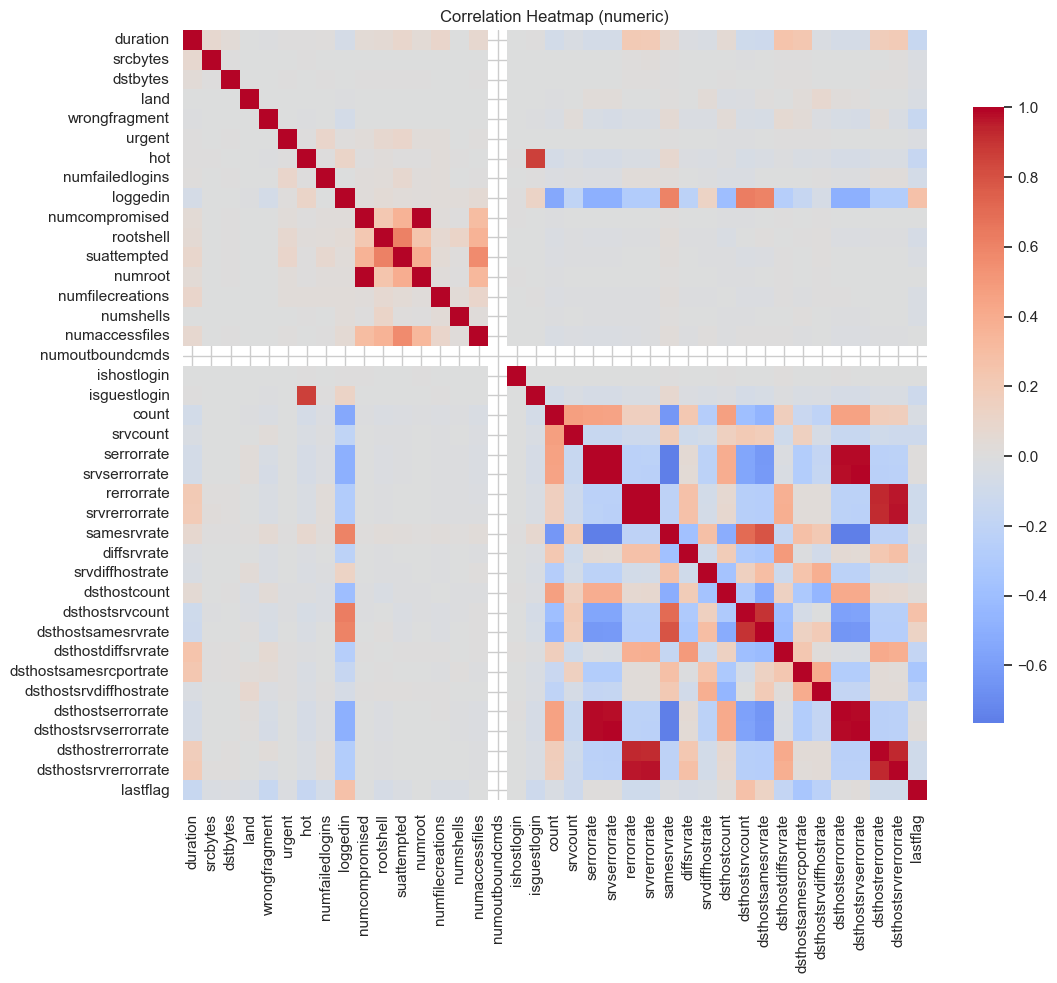

,feature_1,feature_2,correlation,abs_corr
299,numcompromised,numroot,0.998833,0.998833
550,serrorrate,srvserrorrate,0.993289,0.993289
583,rerrorrate,srvrerrorrate,0.989008,0.989008
579,srvserrorrate,dsthostsrvserrorrate,0.986252,0.986252
693,dsthostserrorrate,dsthostsrvserrorrate,0.985052,0.985052
563,serrorrate,dsthostsrvserrorrate,0.981139,0.981139
562,serrorrate,dsthostserrorrate,0.979373,0.979373
578,srvserrorrate,dsthostserrorrate,0.977596,0.977596
610,srvrerrorrate,dsthostsrvrerrorrate,0.970208,0.970208
596,rerrorrate,dsthostsrvrerrorrate,0.964449,0.964449


In [6]:
# Cell 6: Correlation analysis (numeric) + top pairs

num_df = df.select_dtypes(include=[np.number]).copy()
if not num_df.empty and num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"shrink": 0.8})
    plt.title("Correlation Heatmap (numeric)")
    plt.show()

    # Top absolute correlations (pairs)
    tri = (
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    tri["abs_corr"] = tri["correlation"].abs()
    top_pairs = tri.sort_values("abs_corr", ascending=False).head(30)
    display(top_pairs)
else:
    print("Not enough numeric columns for correlation.")

In [7]:
# Cell 7: Outlier detection via IQR for numerics

def iqr_outliers(s: pd.Series):
    x = pd.to_numeric(s, errors="coerce").dropna()
    if x.empty: 
        return 0, 0.0, np.nan, np.nan
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0, 0.0, q1, q3
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask = (x < lower) | (x > upper)
    count = int(mask.sum())
    pct = count / len(x) * 100
    return count, pct, lower, upper

rows = []
for col in num_cols:
    c, p, lo, hi = iqr_outliers(df[col])
    rows.append({"column": col, "outliers": c, "outlier_pct": round(p, 3), "lower_fence": lo, "upper_fence": hi})
outliers_df = pd.DataFrame(rows).sort_values("outlier_pct", ascending=False)
display(outliers_df.head(30))

,column,outliers,outlier_pct,lower_fence,upper_fence
32,dsthostsamesrcportrate,25052,19.887,-0.090,0.150
2,dstbytes,23579,18.718,-774.000,1290.000
1,srcbytes,13840,10.986,-414.000,690.000
20,srvcount,12054,9.569,-22.000,42.000
33,dsthostsrvdiffhostrate,11682,9.273,-0.030,0.050
31,dsthostdiffsrvrate,10550,8.375,-0.105,0.175
26,diffsrvrate,7788,6.182,-0.090,0.150
19,count,3157,2.506,-209.500,354.500
38,lastflag,2995,2.377,13.500,25.500
6,hot,0,0.000,0.000,0.000


In [8]:
# Cell 8: Time series analysis (if any datetime-like columns exist)

# Attempt to parse any datetime-like columns heuristically
dt_candidates = [c for c in df.columns if any(x in c for x in ["time", "timestamp", "date", "datetime"])]
parsed_dt_cols = []
for c in dt_candidates:
    try:
        parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
        if parsed.notna().mean() > 0.6:
            df[c] = parsed
            parsed_dt_cols.append(c)
    except Exception:
        pass

if parsed_dt_cols:
    main_dt = parsed_dt_cols[0]
    daily = df[main_dt].dropna().dt.floor("D").value_counts().sort_index().rename_axis(main_dt).reset_index(name="count")
    if "attack_binary" in df:
        tmp = df.dropna(subset=[main_dt]).copy()
        tmp["day"] = tmp[main_dt].dt.floor("D")
        daily_label = (
            tmp.groupby(["day","attack_binary"])
              .size().reset_index(name="count")
              .pivot(index="day", columns="attack_binary", values="count")
              .fillna(0.0)
        )
        daily_label["attack_rate"] = daily_label.get("Attack", 0) / daily_label.sum(axis=1)
        display(daily_label.head(20))
    else:
        display(daily.head(20))
else:
    print("No datetime-like columns detected or parseable; skipping time series.")

C:\Users\167080\AppData\Local\Temp\ipykernel_33236\836991810.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
C:\Users\167080\AppData\Local\Temp\ipykernel_33236\836991810.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


attack_binary,Attack,Normal,attack_rate
day,,,
2025-08-12,58630,67343,0.465417


In [9]:
# Cell 9: Hypothesis tests utilities

def cohens_d(x, y):
    x = pd.to_numeric(x, errors="coerce").dropna()
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(x) < 2 or len(y) < 2:
        return np.nan
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    # pooled std (unequal sizes)
    s = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    if s == 0: 
        return np.nan
    return (x.mean() - y.mean()) / s

def cramers_v(confusion):
    chi2, p, dof, exp = stats.chi2_contingency(confusion)
    n = confusion.values.sum()
    k = min(confusion.shape) - 1
    if n == 0 or k == 0:
        return np.nan, p
    v = np.sqrt(chi2 / (n * k))
    return v, p

In [10]:
# Cell 10: Hypothesis 1 – Traffic volume vs anomalies (t-tests; normal vs attack)

if label_col and srcbytes_col and dstbytes_col:
    mask_attack = df["attack_binary"] == "Attack"
    # Log-transform heavy tails
    log_src = np.log1p(pd.to_numeric(df[srcbytes_col], errors="coerce"))
    log_dst = np.log1p(pd.to_numeric(df[dstbytes_col], errors="coerce"))

    a_src, n_src = log_src[mask_attack], log_src[~mask_attack]
    a_dst, n_dst = log_dst[mask_attack], log_dst[~mask_attack]

    t_src = stats.ttest_ind(a_src.dropna(), n_src.dropna(), equal_var=False)
    t_dst = stats.ttest_ind(a_dst.dropna(), n_dst.dropna(), equal_var=False)

    d_src = cohens_d(a_src, n_src)
    d_dst = cohens_d(a_dst, n_dst)

    print(f"SrcBytes (log1p): t={t_src.statistic:.3f}, p={t_src.pvalue:.3e}, Cohen's d={d_src:.3f}")
    print(f"DstBytes (log1p): t={t_dst.statistic:.3f}, p={t_dst.pvalue:.3e}, Cohen's d={d_dst:.3f}")

    # Optional ANOVA across attack_family
    if "attack_family" in df:
        groups_src = [log_src[df["attack_family"] == g].dropna() for g in df["attack_family"].unique()]
        groups_dst = [log_dst[df["attack_family"] == g].dropna() for g in df["attack_family"].unique()]
        if len(groups_src) >= 2:
            f_src = stats.f_oneway(*groups_src)
            f_dst = stats.f_oneway(*groups_dst)
            print(f"ANOVA log(SrcBytes) across families: F={f_src.statistic:.3f}, p={f_src.pvalue:.3e}")
            print(f"ANOVA log(DstBytes) across families: F={f_dst.statistic:.3f}, p={f_dst.pvalue:.3e}")
else:
    print("Skipping Hypothesis 1: required columns not found.")

SrcBytes (log1p): t=-373.483, p=0.000e+00, Cohen's d=-2.138
DstBytes (log1p): t=-424.794, p=0.000e+00, Cohen's d=-2.294
ANOVA log(SrcBytes) across families: F=40721.038, p=0.000e+00
ANOVA log(DstBytes) across families: F=42477.266, p=0.000e+00


In [11]:
# Cell 11: Hypothesis 2 – Protocol vs anomalies (chi-square)

if label_col and protocol_col:
    cont = pd.crosstab(df[protocol_col], df["attack_binary"])
    v, p = cramers_v(cont)
    print("Chi-square Protocol x AttackBinary:")
    print(f"Cramer's V = {v:.3f}, p = {p:.3e}")
    display(cont)
else:
    print("Skipping Hypothesis 2: required columns not found.")

Chi-square Protocol x AttackBinary:
Cramer's V = 0.282, p = 0.000e+00


attack_binary,Attack,Normal
protocoltype,,
icmp,6982,1309
tcp,49089,53600
udp,2559,12434


In [12]:
# Cell 12: Hypothesis 3 – Service vs anomalies (chi-square, using Top-N services)

if label_col and service_col:
    top_services = df[service_col].astype("string").value_counts().head(TOP_N).index
    df_srv = df.copy()
    df_srv["service_top"] = np.where(df_srv[service_col].astype("string").isin(top_services), df_srv[service_col], "Other")
    cont = pd.crosstab(df_srv["service_top"], df_srv["attack_binary"])
    v, p = cramers_v(cont)
    print("Chi-square Service(Top-N) x AttackBinary:")
    print(f"Cramer's V = {v:.3f}, p = {p:.3e}")
    display(cont.sort_values(by="Attack", ascending=False, axis=0) if "Attack" in cont.columns else cont)
else:
    print("Skipping Hypothesis 3: required columns not found.")

Chi-square Service(Top-N) x AttackBinary:
Cramer's V = 0.840, p = 0.000e+00


attack_binary,Attack,Normal
service_top,,
private,20871,982
Other,14624,1282
eco_i,4089,497
ecr_i,2887,190
http,2289,38049
ftp_data,1876,4984
other,1755,2604
telnet,1436,917
finger,1222,545


In [13]:
# Cell 13: Hypothesis 4 – Connection status (Flag) and anomalies (logistic regression)

if label_col and flag_col:
    # Prepare data
    X = pd.get_dummies(df[[flag_col]], drop_first=True)
    y = (df["attack_binary"] == "Attack").astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

    clf = LogisticRegression(max_iter=1000, n_jobs=None)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    print(f"AUC = {auc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    coef = pd.Series(clf.coef_[0], index=X.columns, name="coef")
    odds = np.exp(coef).rename("odds_ratio")
    imp = pd.concat([coef, odds], axis=1).sort_values("odds_ratio", ascending=False)
    display(imp.head(20))
else:
    print("Skipping Hypothesis 4: required columns not found.")

AUC = 0.889
              precision    recall  f1-score   support

           0      0.844     0.949     0.893     16836
           1      0.931     0.799     0.860     14658

    accuracy                          0.879     31494
   macro avg      0.888     0.874     0.877     31494
weighted avg      0.885     0.879     0.878     31494



,coef,odds_ratio
flag_S0,3.687955,39.963040
flag_SH,3.326090,27.829306
flag_RSTOS0,2.334729,10.326656
flag_RSTR,1.834251,6.260446
flag_RSTO,1.016629,2.763863
flag_REJ,0.329572,1.390372
flag_S3,-2.173188,0.113814
flag_SF,-2.543552,0.078587
flag_S2,-3.070880,0.046380
flag_S1,-4.610181,0.009950


In [14]:
# Cell 14: Hypothesis 5 – Urgent packets and anomalies (logistic regression, univariate + multivariate)

if label_col and urgent_col:
    y = (df["attack_binary"] == "Attack").astype(int)
    X_uni = pd.DataFrame({urgent_col: pd.to_numeric(df[urgent_col], errors="coerce").fillna(0.0)})

    # Univariate
    X_train, X_test, y_train, y_test = train_test_split(X_uni, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    clf_uni = LogisticRegression(max_iter=1000)
    clf_uni.fit(X_train, y_train)
    auc_uni = roc_auc_score(y_test, clf_uni.predict_proba(X_test)[:, 1])
    odds_uni = float(np.exp(clf_uni.coef_[0][0]))
    print(f"Univariate urgent -> Attack AUC={auc_uni:.3f}, odds_ratio={odds_uni:.3f}")

    # Multivariate: control for traffic volume (log bytes) and duration if available
    feats = {urgent_col: pd.to_numeric(df[urgent_col], errors="coerce").fillna(0.0)}
    if srcbytes_col: feats["log_srcbytes"] = np.log1p(pd.to_numeric(df[srcbytes_col], errors="coerce"))
    if dstbytes_col: feats["log_dstbytes"] = np.log1p(pd.to_numeric(df[dstbytes_col], errors="coerce"))
    if duration_col: feats["log_duration"] = np.log1p(pd.to_numeric(df[duration_col], errors="coerce"))
    X_multi = pd.DataFrame(feats).fillna(0.0)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_multi)

    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    clf_multi = LogisticRegression(max_iter=1000)
    clf_multi.fit(X_train, y_train)
    auc_multi = roc_auc_score(y_test, clf_multi.predict_proba(X_test)[:, 1])

    coefs = pd.Series(clf_multi.coef_[0], index=X_multi.columns, name="std_coef")
    display(pd.DataFrame({"std_coef": coefs}).sort_values("std_coef", ascending=False))
    print(f"Multivariate AUC={auc_multi:.3f}")
else:
    print("Skipping Hypothesis 5: required columns not found.")

Univariate urgent -> Attack AUC=0.500, odds_ratio=1.000


,std_coef
log_duration,0.085387
urgent,0.035077
log_srcbytes,-1.130810
log_dstbytes,-2.113816


Multivariate AUC=0.945
